In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [68]:
from datetime import datetime
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
import datetime as dt

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#Inspect content of measurement class
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
print("name |", "type")
for c in columns:
    print(c['name'], "|", c["type"])

name | type
id | INTEGER
station | TEXT
date | TEXT
prcp | FLOAT
tobs | FLOAT


In [11]:
#Inspect content of station class
inspector = inspect(engine)
columns = inspector.get_columns('station')
print("name |", "type")
for c in columns:
    print(c['name'], "|", c["type"])

name | type
id | INTEGER
station | TEXT
name | TEXT
latitude | FLOAT
longitude | FLOAT
elevation | FLOAT


In [12]:
#Determine last date in Measurement
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
year_ago= (dt.datetime.strptime(str(last_date[0]),"%Y-%m-%d"))-dt.timedelta(days=365)

In [14]:
#Design a query to retrieve the last 12 months of precipitation data (using 8/23/2017 as end date)
sel = [Measurement.date,Measurement.prcp]

last_twelve = session.query(*sel).filter(Measurement.date > (year_ago)).order_by(Measurement.date).all()
#last_twelve

In [15]:
#Create Pandas dataframe with date and prcp. Drop null values and group by date to aggregate precipation on dates.
last_twelve_df = pd.DataFrame(last_twelve, columns=['date', 'prcp'])
last_twelve_dropna = last_twelve_df.dropna()
agg_last_twelve = last_twelve_dropna.groupby(["date"]).sum().sort_index()
agg_last_twelve.head()

,prcp
date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10


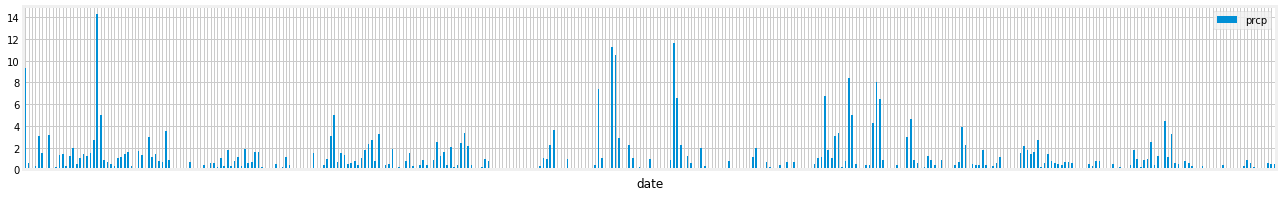

In [16]:
#Use dataframe plot method to create bar chart
myplot = agg_last_twelve.plot.bar(figsize=(20,3))
#myplot = last_twelve_dropna.plot.bar()
myplot.axes.xaxis.set_ticklabels([])
ax = plt.gca()
ax.set_facecolor("white")
plt.savefig('twelve_months.png', bbox_inches='tight')
plt.show()

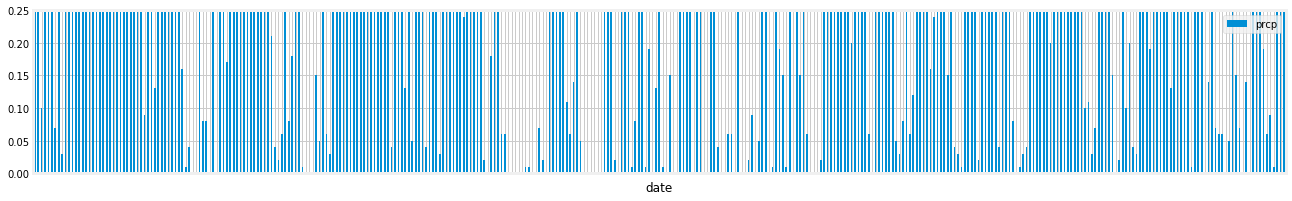

In [17]:
#Show plot with magnification near y=0 to show the gaps are not gaps - just very little precipitation
myplot = agg_last_twelve.plot.bar(figsize=(20,3))
#myplot = last_twelve_dropna.plot.bar()
myplot.axes.xaxis.set_ticklabels([])
plt.ylim(0,.25)
ax = plt.gca()
ax.set_facecolor("white")
plt.savefig('twelve_months.png', bbox_inches='tight')
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_twelve_dropna.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [58]:
# Design a query to show how many stations are available in this dataset?

selall = [Measurement.tobs,Measurement.date]

# name | type
# id | INTEGER
# station | TEXT
# date | TEXT
# prcp | FLOAT
# tobs | FLOAT

no_stations = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"Number of stations in dataset: {no_stations}")

Number of stations in dataset: 9


In [59]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_data = session.query(Measurement.station,             
    func.count(Measurement.id).label('qty')
    ).group_by(Measurement.station
    ).order_by(desc('qty'))
for station in station_data:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [60]:
temp_recordings = session.query(func.min(Measurement.tobs).label('low'),\
                                func.max(Measurement.tobs).label('high'),\
                                func.avg(Measurement.tobs).label('avg')
        ).filter(Measurement.station == "USC00519281").first()
print(f"Temp recordings (degrees) at most active station: Low: {temp_recordings[0]}, High: {temp_recordings[1]}, Average: {temp_recordings[2]}")

Temp recordings (degrees) at most active station: Low: 54.0, High: 85.0, Average: 71.66378066378067


In [61]:
# Choose the station with the highest number of temperature observations. 
# Query the last 12 months of temperature observation data (tobs)
last_year_tobs = session.query(*selall).filter(Measurement.date > (year_ago)).order_by(Measurement.tobs).\
                                            filter(Measurement.station == "USC00519281").all()
#last_year_tobs

In [62]:
#Create Pandas dataframe with tobs and date. Drop null values and group by tobs to count tobs frequencies.
last_year_tobs_df = pd.DataFrame(last_year_tobs, columns=['tobs','date'])
last_year_tobs_dropna = last_year_tobs_df.dropna()
agg_last_year_tobs = last_year_tobs_dropna.groupby(["tobs"]).count().reset_index()
agg_last_year_tobs=agg_last_year_tobs.set_index("tobs")
agg_last_year_tobs = agg_last_year_tobs.rename(columns = {"date":"Frequency"}).sort_index()
agg_last_year_tobs.head()

,Frequency
tobs,
59.0,3
60.0,2
61.0,1
62.0,6
63.0,4


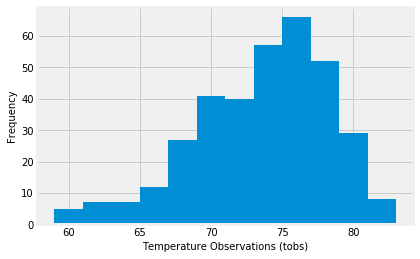

In [63]:
#Plot a histogram showing frequencies of temperature observations at most active station (with bin=12)
plt.hist(last_year_tobs_dropna["tobs"], bins=12)
plt.xlabel("Temperature Observations (tobs)",fontsize="medium")
plt.ylabel("Frequency",fontsize="medium")
plt.savefig('last_twelve_tobs.png', bbox_inches='tight')
plt.show()

In [64]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    print(start_date)

# function usage example
#print(calc_temps('2012-02-28', '2012-03-05'))
#print(calc_temps(start_date, end_date))

In [65]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates. My dates 01-25 to 02-01
mytrip = calc_temps('2017-01-25','2017-02-01')
# Convert list of tuples into normal list
my_trip_stats = list(np.ravel(mytrip))
my_trip_stats

[62.0, 69.0576923076923, 76.0]

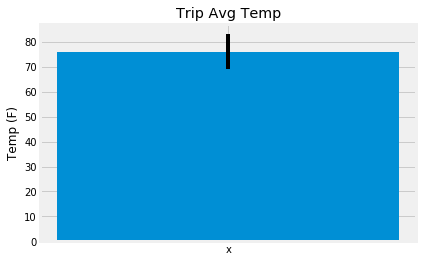

In [66]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar("x",my_trip_stats[2],yerr=(my_trip_stats[1]-my_trip_stats[0]))
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.savefig('trip_avg_temp.png', bbox_inches='tight')
plt.show()

In [67]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

seljoin = [Measurement.date,func.sum(Measurement.prcp), Measurement.station, Station.station, Station.name,
           Station.latitude, Station.longitude, Station.elevation]

trip_total = session.query(Measurement.station, Station.name,Station.latitude, Station.longitude, Station.elevation,  
            func.sum(Measurement.prcp).label('total_prcp')).\
            filter(Measurement.date >= '2017-01-25').\
            filter(Measurement.date <= '2017-02-01').group_by(Measurement.station).order_by(desc('total_prcp')).\
            filter(Measurement.station == Station.station).all()

for station in trip_total:
    print(station)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 3.3200000000000003)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.08)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.26)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.21)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.05)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.01)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)


## Optional Challenge Assignment

In [20]:
#I DID NOT DO THE CHALLENGE BECAUSE I RAN OUT OF TIME; HOWEVER, I LEFT IT HERE SO I CAN GO BACK AND DO IT LATER!!
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


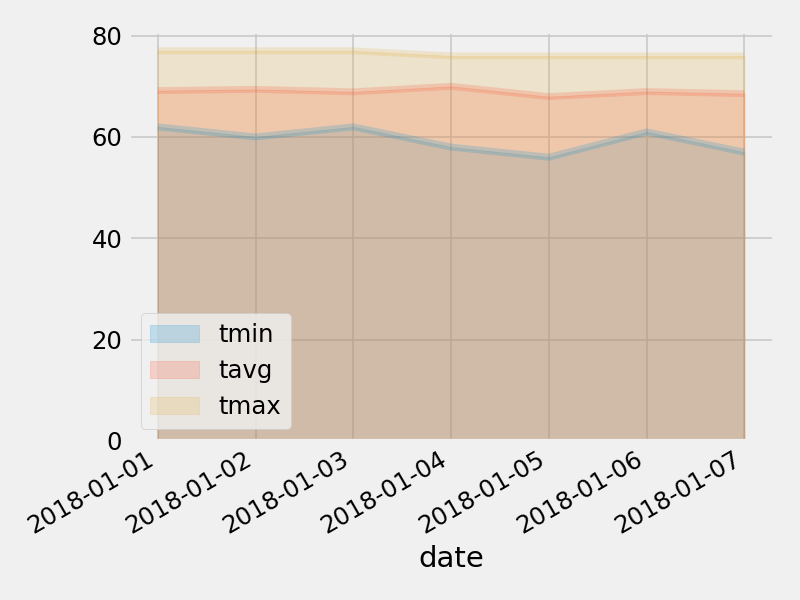

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
